# Modelling a continuous stirred tank reactor controlled by a PID controller


## Mathematical modelling


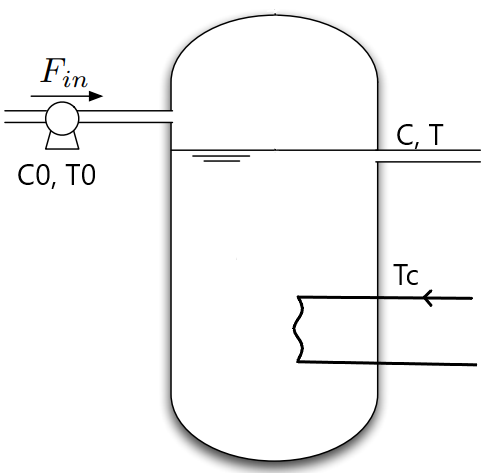

In [1]:
from IPython.display import Image
Image(filename="img/cstr.png")

In this tank, we have a isomerization reaction and the tank's input is a feed stream of constant concentration $C_0$ and constant temperature $T_0$. The temperature can be controller through the circuit of temperature $T_C$. This temperature is the control variable for which the PID is designed. The temperature and concentration of the tank and the output are the state variables $T$ and $C$. We want $C$ to reach a setpoint $C^*$.


With the Arrhenius' law of reaction, we have the following differential equations:
\begin{align*}
   C' &= K_1 (C_0 - C) - K_3 exp \left( \frac{-K_4}{T} \right) C \\
    T' &= K_1(T_0 - T) + K_2 K_3 exp \left( \frac{-K_4}{T} \right) C - K_3 (T-T_C) \\
    T_C &= K_p e(t) + K_i \int_{0}^{t} e(\tau) d\tau + K_d e'(t)
\end{align*}
where $e(t) = C - C^*$. This system is a index 1 DAEs system that can be written as follows:

\begin{align*}
   C' &= K_1 (C_0 - C) - K_3 exp \left( \frac{-K_4}{T} \right) C \\
    T' &= K_1(T_0 - T) + K_2 K_3 exp \left( \frac{-K_4}{T} \right) C - K_3 (T-T_C) \\
    I' &= e(t)\\
    T_C &= K_p e(t) + K_i I(t) + K_d e'(t)
\end{align*}

Constants have been taken from the [article](https://doi.org/10.1093/imamci/dnz015) of Raymundo Juarez et al. which is referenced at the end of this notebook.

By the deriving the constraint we get the ODEs system:
\begin{align*}
   C' &= K_1 (C_0 - C) - K_3 exp \left( \frac{-K_4}{T} \right) C \\
    T' &= K_1(T_0 - T) + K_2 K_3 exp \left( \frac{-K_4}{T} \right) C - K_3 (T-T_C) \\
    T_C' &= K_p e'(t) + K_i e(t) + K_d e''(t)
\end{align*}
in which $e'(t) = C'$ and $e''(t)$ is obtained by deriving the right hand side of the first equation.

## Solving those systems with DAEs solvers

In [2]:
# import solvers
from solvers.bdfSolver import BDFModified
from solvers.sabm import SABM
from solvers.radau import RadauModified
from solvers.rosScipyFinal import Rosenbrock

In [3]:
# import other useful modules
from time import time
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

Declare the constants of our CSTR problem:

In [4]:
qr = 0.08  # [m^3· s^-1]
Vr = 1.2  # [m^3]
h1 = 4.8 * 10**4  # [kJ · kmol^-1]
rhor = 985  # [kg · m^-3]
cpr = 4.05  # [kJ · kg^-1 · K^-1]
U = 43.5  # [kJ · sec^-1 m^-2 K^-1]
Ar = 5.5  # [m^2]

K1 = qr/Vr
K2 = h1/(rhor*cpr)
K3 = (Ar*U)/(Vr*rhor*cpr)
K4 = 1347       # [K]

C0 = 150
T0 = 600

sp = 140
Kp = 5
Ki = 1

Create the function describing the DAEs systems such that $M \dot{y} = f(t,y)$:

In [5]:
# right hand side (rhs) of the index 1 DAEs system
def cstrdae(t, y):
    C, T, I, TC = y
    return np.array([K1*(C0-C) - K3*np.exp(-K4/T)*C,
                     K1*(T0-T) + K2*K3*np.exp(-K4/T)*C - K3*(T-TC),
                     C-sp,
                     TC - Kp*(C-sp) - Ki*I])

# mass matrix
M = np.eye(4)
M[-1, -1] = 0

# rhs of the ODEs part of the DAEs system
def fun(t, y, x):
    C, T, I = y
    TC = x[0]
    return np.array([K1*(C0-C) - K3*np.exp(-K4/T)*C,
                     K1*(T0-T) + K2*K3*np.exp(-K4/T)*C - K3*(T-TC),
                     C-sp])

# constraint
def gun(t, y, x):
    C, T, I = y
    TC = x[0]
    return np.array([TC - Kp*(C-sp) - Ki*I])

Initial conditions:

In [6]:
c0 = C0+100
t0 = T0-150
tc0 = Kp*(c0-sp)

y0 = [c0, t0, 0, tc0]
tspan = [0, 200]

Parameters of the DAEs solvers similar to those scipy solve_ivp:

In [7]:
kwargsBDF = {
    'fun': cstrdae,
    't_span': tspan,
    'y0': y0,
    'mass': M,
    'method': BDFModified,
    'rtol': 1e-5,
    'atol': 1e-5,
    'first_step': 1e-8,
}


kwargsRadau = {
    'fun': cstrdae,
    't_span': tspan,
    'y0': y0,
    'mass': M,
    'method': RadauModified,
    'rtol': 1e-5,
    'atol': 1e-5,
    'dense_output': False
}

kwargsSABM = {
    'fun': fun,
    't_span': tspan,
    'y0': y0,
    'method': SABM,
    'gun': gun,
    'num_diff': 3,
    'order': 2,
    'atol': 1e-5,
    'rtol': 1e-5,
    'mode': 'Explicit'
}

Solve the DAEs system using the scipy solve_ivp function:

In [8]:
kwargs = kwargsSABM

before = time()
sol = solve_ivp(**kwargs)
print(f'Success: {sol.success}')
print(f'Temps de calcul : {time()-before}')
t = sol.t

C = sol.y[0, :]
T = sol.y[1, :]
TC = sol.y[3, :]

Success: True
Temps de calcul : 3.190310478210449


Solve the ODEs system:

In [9]:
def solve_ODE():
    def cstrode(t, y):
        C, T, TC = y
        dCdt  = K1*(C0-C) - K3*np.exp(-K4/T)*C
        dTdt  = K1*(T0-T) + K2*K3*np.exp(-K4/T)*C - K3*(T-TC)
        dTCdt = Kp*dCdt + Ki*(C-sp) 
        return np.array([dCdt, dTdt, dTCdt])

    y0 = np.array([c0, t0, tc0])
    sol_ODE = solve_ivp(fun=cstrode, t_span=[0, sol.t[-1]], y0=y0, rtol=1e-12,
                        atol=1e-12, method='DOP853', t_eval=sol.t)
    
    return sol_ODE.t, sol_ODE.y[0, :], sol_ODE.y[1, :], sol_ODE.y[2, :]

t_ODE, C_ODE, T_ODE, TC_ODE = solve_ODE()

Plot the evolution of the system's variables over time:

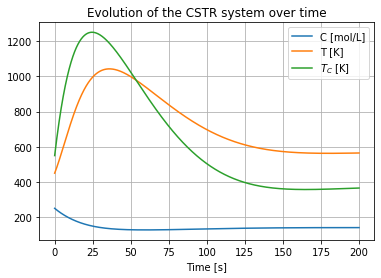

In [10]:
plt.figure()
plt.plot(t, C, label="C [mol/L]")
plt.plot(t, T, label="T [K]")
plt.plot(t, TC, label="$T_C$ [K]")
plt.title("Evolution of the CSTR system over time")
plt.xlabel("Time [s]")
plt.grid()
plt.legend()
plt.show()

Note that the concentration $C$ has reached its setpoint $C^*$:

In [11]:
print(f'Concentration C at time {t[-1]}[s]: {C[-1]}[mol/L]')

Concentration C at time 200.0[s]: 140.31033936772766[mol/L]


Plot the error of our DAEs solver:

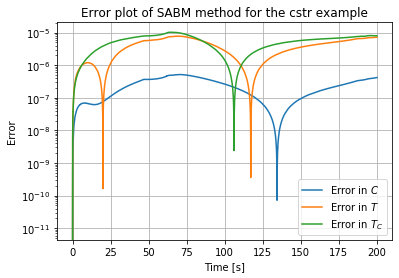

In [12]:
plt.figure()
plt.semilogy(t, abs(C_ODE - C), label='Error in $C$')
plt.semilogy(t, abs(T_ODE - T), label='Error in $T$')
plt.semilogy(t, abs(TC_ODE - TC), label='Error in $T_C$')
plt.title(
    f'Error plot of {kwargs["method"].__name__} method for the cstr example')
plt.xlabel('Time [s]')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.show()

## References

Raymundo Juarez, Vadim Azhmyakov, A Tadeo Espinoza, Francisco G Salas, An implicit class of continuous dynamical system with data-sample outputs: a robust approach, IMA Journal of Mathematical Control and Information, Volume 37, Issue 2, June 2020, Pages 589–606, https://doi.org/10.1093/imamci/dnz015